# Étape 1 — Exploration & Non-Supervisé (ECG battements en CSV)

Le notebook est conçu pour tes fichier CSV de type **PTBDB** / **MIT-BIH** (battements segmentés), où :  
- `X = toutes les colonnes sauf la dernière`  
- `y = dernière colonne` (classe)

Fichiers typiques :
- `ptbdb_normal.csv`, `ptbdb_abnormal.csv`
- `mitbih_train.csv`, `mitbih_test.csv`

Objectifs :
1) Charger et nettoyer les données (NaN, types)  
2) EDA rapide (quelques battements, distributions)  
3) Extraire des features (stat + morpho)  
4) Standardiser, PCA (visualisation)  
5) Clustering (KMeans + DBSCAN) + métriques (silhouette, etc.)  


In [15]:

import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


## 1) Configuration des chemins

Renseigne `DATA_DIR` vers le dossier contenant tes CSV.


In [16]:

# Racine réelle = parent du dossier Projet
PROJECT_ROOT = Path.cwd().parent

DATA_DIR = PROJECT_ROOT / "Dataset Projet"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("Existe ?", DATA_DIR.exists())

FILES = {
    "ptbdb_normal": "ptbdb_normal.csv",
    "ptbdb_abnormal": "ptbdb_abnormal.csv",
    "mitbih_train": "mitbih_train.csv",
    "mitbih_test": "mitbih_test.csv",
}

# Vérification rapide
for k, f in FILES.items():
    p = DATA_DIR / f
    print(f"{k:>14} -> {'OK' if p.exists() else 'MANQUANT'} : {p}")


PROJECT_ROOT: /Users/raphc/Documents/Cours M2/algorithmique supervisé
DATA_DIR: /Users/raphc/Documents/Cours M2/algorithmique supervisé/Dataset Projet
Existe ? True
  ptbdb_normal -> OK : /Users/raphc/Documents/Cours M2/algorithmique supervisé/Dataset Projet/ptbdb_normal.csv
ptbdb_abnormal -> OK : /Users/raphc/Documents/Cours M2/algorithmique supervisé/Dataset Projet/ptbdb_abnormal.csv
  mitbih_train -> OK : /Users/raphc/Documents/Cours M2/algorithmique supervisé/Dataset Projet/mitbih_train.csv
   mitbih_test -> OK : /Users/raphc/Documents/Cours M2/algorithmique supervisé/Dataset Projet/mitbih_test.csv


## 2) Chargement des CSV

Fonctions robustes :
- lecture `header=None`
- conversion numérique (`to_numeric(errors="coerce")`)
- split X / y


In [17]:

# Cellule 3 — Chargement + split X/y

def load_ecg_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, header=None)
    # conversion numérique (sécurise contre valeurs parasites)
    df = df.apply(pd.to_numeric, errors="coerce")
    return df

def split_xy(df: pd.DataFrame):
    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    return X, y

dfs = {}
for name, fname in FILES.items():
    p = DATA_DIR / fname
    if p.exists():
        dfs[name] = load_ecg_csv(p)
        print(name, dfs[name].shape)
    else:
        print("Skip (manquant):", name, p)


ptbdb_normal (4046, 188)
ptbdb_abnormal (10506, 188)
mitbih_train (87554, 188)
mitbih_test (21892, 188)


## 3) Construire un dataset de travail

Choisis une stratégie :
- soit tu fais **PTBDB uniquement**
- soit tu fais **MIT-BIH uniquement**
- soit tu concatènes tout (attention : distributions parfois différentes)

Par défaut, on concatène PTBDB normal/abnormal si disponibles.


In [18]:

# Cellule 4 — Construction du dataset X, y

def concat_available(parts):
    parts = [p for p in parts if p is not None]
    if not parts:
        return None
    return pd.concat(parts, ignore_index=True)

X_list, y_list = [], []

# PTBDB
if "ptbdb_normal" in dfs and "ptbdb_abnormal" in dfs:
    Xn, yn = split_xy(dfs["ptbdb_normal"])
    Xa, ya = split_xy(dfs["ptbdb_abnormal"])
    X_ptb = concat_available([Xn, Xa])
    y_ptb = concat_available([yn, ya])
else:
    X_ptb, y_ptb = None, None

# MIT-BIH (train + test)
if "mitbih_train" in dfs and "mitbih_test" in dfs:
    Xt, yt = split_xy(dfs["mitbih_train"])
    Xv, yv = split_xy(dfs["mitbih_test"])
    X_mit = concat_available([Xt, Xv])
    y_mit = concat_available([yt, yv])
else:
    X_mit, y_mit = None, None

# Choix du dataset principal
USE = "PTBDB"  # "PTBDB" ou "MITBIH"

if USE.upper() == "PTBDB":
    if X_ptb is None:
        raise FileNotFoundError("PTBDB non disponible. Mets USE='MITBIH' ou vérifie les fichiers.")
    X, y = X_ptb, y_ptb
else:
    if X_mit is None:
        raise FileNotFoundError("MIT-BIH non disponible. Mets USE='PTBDB' ou vérifie les fichiers.")
    X, y = X_mit, y_mit

print("Dataset choisi:", USE)
print("X:", X.shape, "y:", y.shape)
print("Classes:", y.value_counts().to_dict())


Dataset choisi: PTBDB
X: (14552, 187) y: (14552,)
Classes: {1.0: 10506, 0.0: 4046}


## 4) Nettoyage minimal (NaN, lignes vides)

Pour du clustering, on veut des matrices propres.


In [19]:

# Cellule 5 — Nettoyage

# stats NaN
nan_total = int(np.isnan(X.values).sum())
print("NaN total dans X:", nan_total)

# drop rows with any NaN (simple et efficace pour étape 1)
mask_ok = ~np.isnan(X.values).any(axis=1)
X_clean = X.loc[mask_ok].reset_index(drop=True)
y_clean = y.loc[mask_ok].reset_index(drop=True)

print("Après dropna lignes:", X_clean.shape, y_clean.shape)


NaN total dans X: 0
Après dropna lignes: (14552, 187) (14552,)


## 5) EDA rapide : afficher quelques battements

On affiche quelques signaux (lignes de X) pour vérifier.


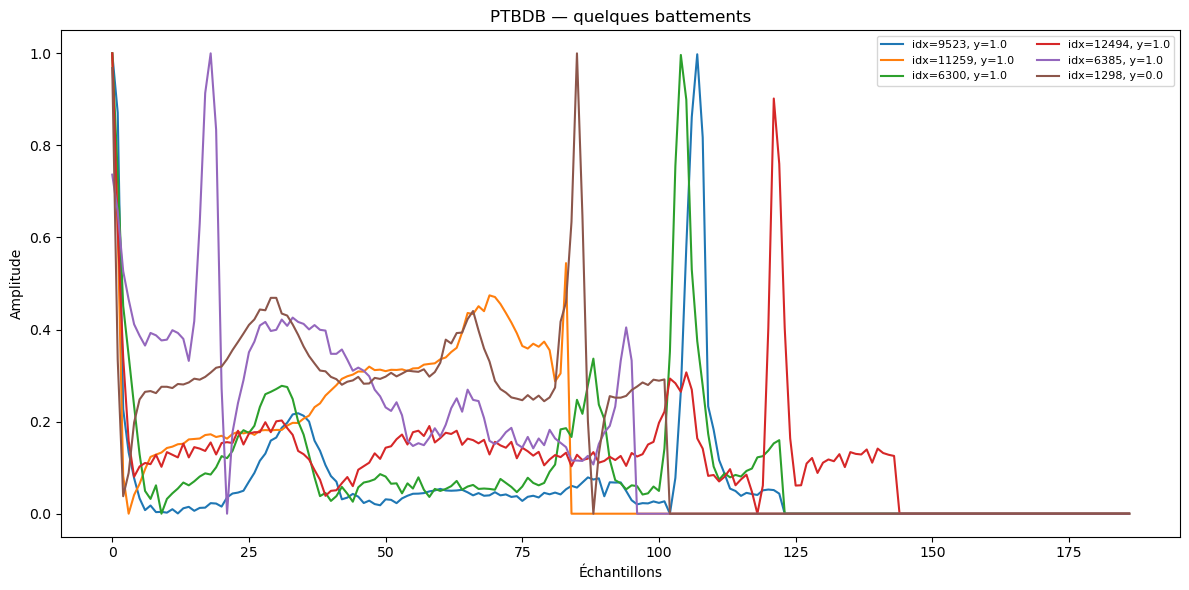

In [20]:

# Cellule 6 — Plots de battements

def plot_random_beats(X_df: pd.DataFrame, y_series: pd.Series, n=6, seed=42, title="Battements aléatoires"):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(X_df), size=min(n, len(X_df)), replace=False)

    plt.figure(figsize=(12, 6))
    for i, j in enumerate(idx):
        plt.plot(X_df.iloc[j].values, label=f"idx={j}, y={y_series.iloc[j]}")
    plt.title(title)
    plt.xlabel("Échantillons")
    plt.ylabel("Amplitude")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()

plot_random_beats(X_clean, y_clean, n=6, seed=42, title=f"{USE} — quelques battements")


## 6) Feature engineering (stat + morpho)

On transforme chaque battement (vecteur longueur ~187) en une ligne de features.


In [21]:

def extract_features_1beat(x: np.ndarray) -> dict:
    x = np.asarray(x, dtype=float)
    dx = np.diff(x)

    feats = {
        "mean": float(x.mean()),
        "std": float(x.std()),
        "min": float(x.min()),
        "max": float(x.max()),
        "ptp": float(x.max() - x.min()),
        "energy": float(np.mean(x**2)),
        "abs_dx_mean": float(np.mean(np.abs(dx))),
        "dx_std": float(np.std(dx)),
        "dx_ptp": float(dx.max() - dx.min()),
    }
    for q in (10, 25, 50, 75, 90):
        feats[f"q{q}"] = float(np.percentile(x, q))
    return feats

def build_feature_table(X_df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for row in X_df.values:
        rows.append(extract_features_1beat(row))
    return pd.DataFrame(rows)

F = build_feature_table(X_clean)
print("Feature table:", F.shape)
F.head()


Feature table: (14552, 14)


,mean,std,min,max,ptp,energy,abs_dx_mean,dx_std,dx_ptp,q10,q25,q50,q75,q90
0,0.119207,0.158221,0.0,1.0,1.0,0.039244,0.023518,0.080205,1.066451,0.0,0.000000,0.115883,0.136548,0.238574
1,0.238641,0.202055,0.0,1.0,1.0,0.097776,0.026423,0.075788,0.781694,0.0,0.000000,0.252319,0.344774,0.449103
2,0.163529,0.147665,0.0,1.0,1.0,0.048547,0.022498,0.069597,0.767973,0.0,0.116354,0.134242,0.186542,0.264872
3,0.073524,0.135009,0.0,1.0,1.0,0.023633,0.021840,0.080401,1.013976,0.0,0.000000,0.043639,0.065459,0.140730
4,0.101952,0.149279,0.0,1.0,1.0,0.032679,0.023642,0.085004,1.077469,0.0,0.037108,0.080130,0.101567,0.202070


## 7) Standardisation + PCA (visualisation)

PCA 2D pour visualiser la structure et les clusters.


In [22]:
scaler = StandardScaler()
F_scaled = scaler.fit_transform(F)

pca2 = PCA(n_components=2, random_state=42)
Z2 = pca2.fit_transform(F_scaled)

print("PCA explained variance ratio:", pca2.explained_variance_ratio_)


PCA explained variance ratio: [0.51143024 0.16266536]


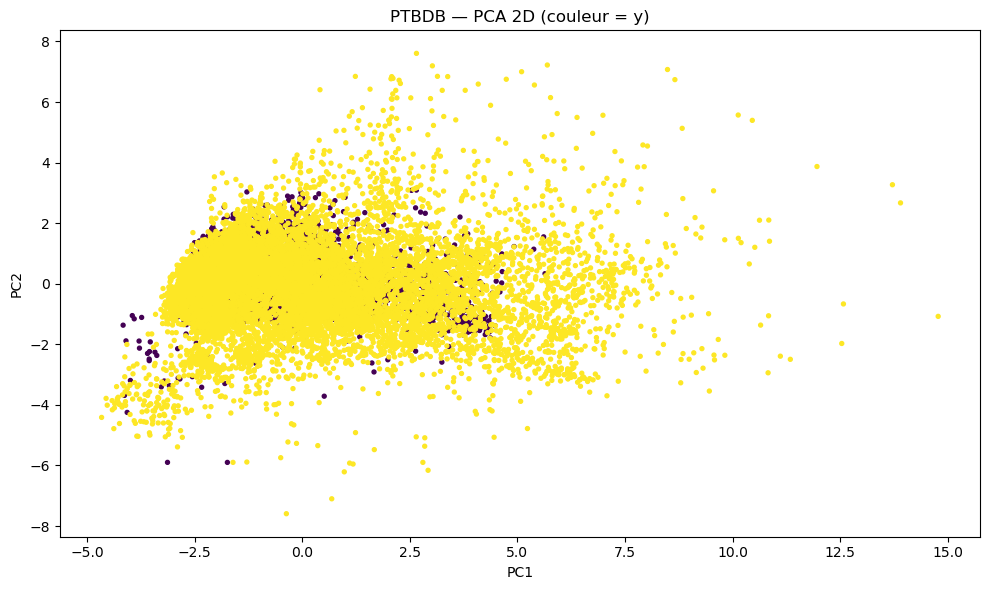

In [23]:

def scatter_pca(Z, c=None, title="PCA 2D"):
    plt.figure(figsize=(10, 6))
    if c is None:
        plt.scatter(Z[:, 0], Z[:, 1], s=8)
    else:
        plt.scatter(Z[:, 0], Z[:, 1], s=8, c=c)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

scatter_pca(Z2, c=y_clean.values, title=f"{USE} — PCA 2D (couleur = y)")


## 8) Clustering KMeans : recherche de k + silhouette

On teste plusieurs k, puis on garde le meilleur selon silhouette.


In [24]:
def kmeans_grid(F_scaled, k_list=range(2, 11), random_state=42):
    results = []
    for k in k_list:
        km = KMeans(n_clusters=k, random_state=random_state, n_init=20, max_iter=500)
        lab = km.fit_predict(F_scaled)

        sil = silhouette_score(F_scaled, lab)
        dbi = davies_bouldin_score(F_scaled, lab)
        ch  = calinski_harabasz_score(F_scaled, lab)

        results.append({"k": k, "silhouette": sil, "davies_bouldin": dbi, "calinski_harabasz": ch})
    return pd.DataFrame(results).sort_values("silhouette", ascending=False)

k_grid = kmeans_grid(F_scaled, k_list=range(2, 11))
k_grid


,k,silhouette,davies_bouldin,calinski_harabasz
0,2,0.444563,1.131704,7979.258620
3,5,0.295704,1.123101,4850.348589
2,4,0.284666,1.180796,5161.581791
1,3,0.282648,1.455196,5695.622268
7,9,0.270602,1.100573,4510.779809
8,10,0.258107,1.077868,4460.174695
6,8,0.255571,1.087639,4577.301221
5,7,0.243570,1.099951,4628.306075
4,6,0.233012,1.130382,4752.788781


Best k: 2
Silhouette (best k): 0.44456297103993686


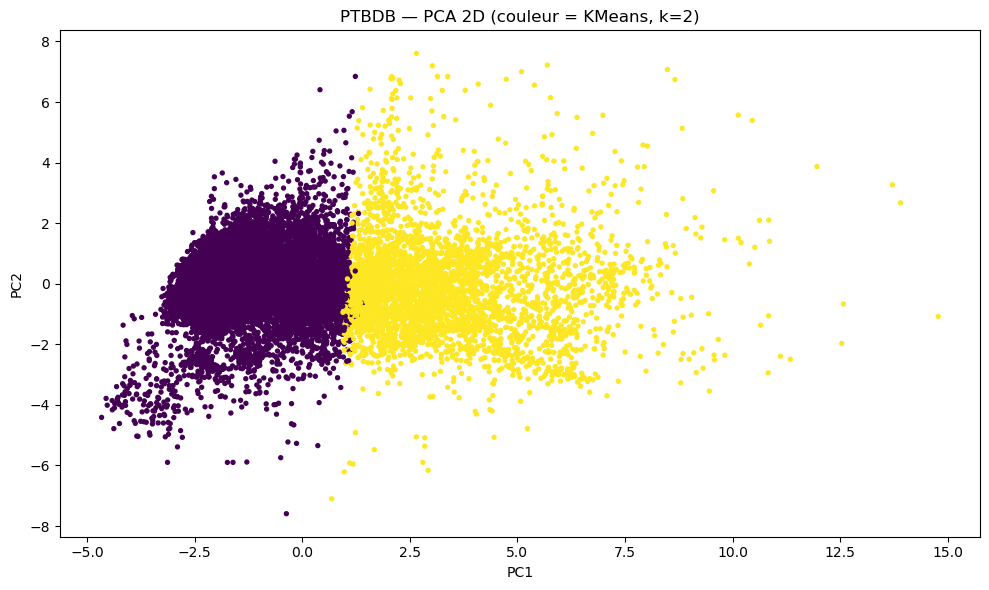

In [25]:
best_k = int(k_grid.iloc[0]["k"])
print("Best k:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20, max_iter=500)
labels_km = kmeans.fit_predict(F_scaled)

print("Silhouette (best k):", silhouette_score(F_scaled, labels_km))
scatter_pca(Z2, c=labels_km, title=f"{USE} — PCA 2D (couleur = KMeans, k={best_k})")


## 9) Clustering DBSCAN

DBSCAN détecte automatiquement le nombre de clusters et marque du bruit (-1).
Astuce :
- standardiser (déjà fait)
- jouer sur `eps` et `min_samples`


In [26]:

def run_dbscan(F_scaled, eps=1.0, min_samples=10):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    lab = db.fit_predict(F_scaled)

    n_clusters = len(set(lab)) - (1 if -1 in lab else 0)
    noise_pct = float(np.mean(lab == -1))

    metrics = {
        "eps": eps,
        "min_samples": min_samples,
        "n_clusters": n_clusters,
        "noise_pct": noise_pct,
        "silhouette_non_noise": None,
    }

    mask = lab != -1
    if mask.sum() > 1 and len(set(lab[mask])) > 1:
        metrics["silhouette_non_noise"] = float(silhouette_score(F_scaled[mask], lab[mask]))

    return lab, metrics

# Teste quelques paramètres
tests = []
labels_db_last = None
for eps in [0.5, 0.8, 1.0, 1.2, 1.5]:
    for ms in [5, 10, 20]:
        lab, m = run_dbscan(F_scaled, eps=eps, min_samples=ms)
        tests.append(m)
        labels_db_last = lab

db_grid = pd.DataFrame(tests).sort_values(
    ["silhouette_non_noise", "n_clusters", "noise_pct"],
    ascending=[False, False, True],
    na_position="last"
)
db_grid.head(10)


,eps,min_samples,n_clusters,noise_pct,silhouette_non_noise
11,1.2,20,3,0.040682,0.590382
14,1.5,20,3,0.023227,0.571177
13,1.5,10,4,0.016767,0.522735
8,1.0,20,4,0.067894,0.513734
7,1.0,10,4,0.048103,0.465425
12,1.5,5,10,0.009689,0.342074
10,1.2,10,6,0.028862,0.280104
4,0.8,10,11,0.087548,0.146838
6,1.0,5,15,0.031542,0.135543
9,1.2,5,12,0.019929,0.135090


{'eps': 1.2, 'min_samples': 20, 'n_clusters': 3, 'noise_pct': 0.04068169323804288, 'silhouette_non_noise': 0.5903815391835553}


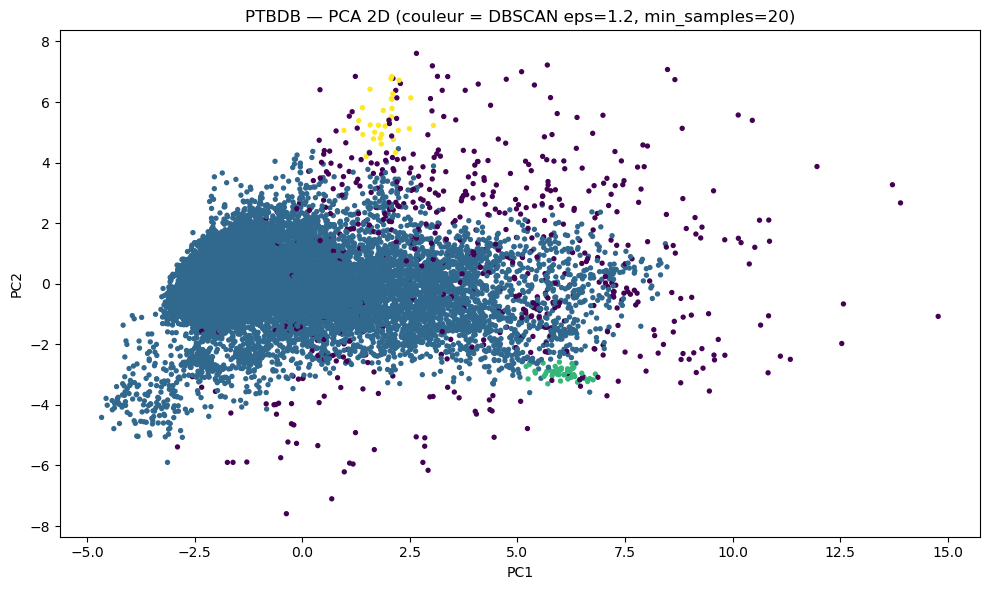

In [27]:

best = db_grid.dropna(subset=["silhouette_non_noise"]).head(1)
if len(best) == 0:
    print("Aucun DBSCAN n'a produit >=2 clusters sans bruit. Essaye d'autres eps/min_samples.")
else:
    eps = float(best.iloc[0]["eps"])
    ms  = int(best.iloc[0]["min_samples"])
    labels_db, metrics_db = run_dbscan(F_scaled, eps=eps, min_samples=ms)
    print(metrics_db)
    scatter_pca(Z2, c=labels_db, title=f"{USE} — PCA 2D (couleur = DBSCAN eps={eps}, min_samples={ms})")


## 10) (Option) Autoencodeur 1D pour embeddings + clustering

Si tu veux une réduction de dimension apprise, tu peux utiliser un autoencodeur Conv1D.
Cette partie est optionnelle et peut être activée si TensorFlow est installé et compatible.


In [28]:

USE_AUTOENCODER = False  # mets True si tu veux essayer

if USE_AUTOENCODER:
    import tensorflow as tf
    from tensorflow.keras import layers as L, Model

    X_sig = X_clean.values.astype("float32")
    # normalisation simple du signal (par battement) pour le NN
    X_sig = (X_sig - X_sig.mean(axis=1, keepdims=True)) / (X_sig.std(axis=1, keepdims=True) + 1e-6)
    X_sig = X_sig[..., None]  # (n, time, 1)

    inp = L.Input(shape=(X_sig.shape[1], 1))
    x = L.Conv1D(16, 5, padding="same", activation="relu")(inp)
    x = L.MaxPool1D(2)(x)
    x = L.Conv1D(32, 5, padding="same", activation="relu")(x)
    x = L.MaxPool1D(2)(x)
    x = L.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = L.GlobalAveragePooling1D()(x)
    z  = L.Dense(16, activation=None, name="embedding")(x)  # embedding 16D

    # decoder
    d = L.Dense((X_sig.shape[1] // 4) * 64, activation="relu")(z)
    d = L.Reshape((X_sig.shape[1] // 4, 64))(d)
    d = L.UpSampling1D(2)(d)
    d = L.Conv1D(32, 5, padding="same", activation="relu")(d)
    d = L.UpSampling1D(2)(d)
    out = L.Conv1D(1, 5, padding="same", activation=None)(d)

    auto = Model(inp, out)
    auto.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
    auto.summary()

    hist = auto.fit(X_sig, X_sig, epochs=10, batch_size=256, validation_split=0.2, verbose=1)

    # embeddings
    encoder = Model(inp, z)
    E = encoder.predict(X_sig, batch_size=512, verbose=0)

    # clustering sur embeddings
    scalerE = StandardScaler()
    E_scaled = scalerE.fit_transform(E)

    kmE = KMeans(n_clusters=best_k, random_state=42, n_init=20)
    labE = kmE.fit_predict(E_scaled)
    print("Silhouette (embeddings):", silhouette_score(E_scaled, labE))

    pcaE = PCA(n_components=2, random_state=42).fit_transform(E_scaled)
    scatter_pca(pcaE, c=labE, title="Embeddings AE — PCA 2D (couleur = KMeans)")


## 11) Résumé 

- Dataset : {PTBDB ou MIT-BIH}  
- Nettoyage : conversion numérique, suppression NaN  
- Features : stats + morpho (dx + quantiles)  
- StandardScaler + PCA 2D pour visualisation  
- KMeans : meilleure silhouette sur k=...  
- DBSCAN : paramètres (eps, min_samples), % bruit, silhouette sans bruit  
- (Option) Autoencodeur 1D : embeddings puis clustering  
